In [2]:
# Imports

import torch
from torch import nn
from torch import optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
from torch.utils.tensorboard import SummaryWriter

from PIL import Image
import matplotlib.pyplot as plt
import datetime
import random
import time

In [68]:
# Define a multilayer perceptron

model = nn.Sequential(
    nn.Linear(28*28, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    # nn.Dropout(.1), # To prevent overfitting
    nn.Linear(64, 10)
)

model_name = "MLP-l64-l64"

In [3]:
# Define more flexible model (resnet)

class ResNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.l1 = nn.Linear(28*28, 64)
        self.l2 = nn.Linear(64, 64)
        self.l3 = nn.Linear(64, 10)
        self.do = nn.Dropout(0.1)
        self.softmax = nn.Softmax(1)

    def forward(self, x):
        h1 = nn.functional.relu(self.l1(x))
        h2 = nn.functional.relu(self.l2(h1))
        do = self.do(h2 + h1)
        h3 = self.l3(do)
        h4 = self.softmax(h3)

        return h3
    
model = ResNet()

model_name = "ResNet"

In [70]:
# Define optimiser

optimiser = optim.SGD(
    model.parameters(),
    lr=1e-2
)

In [71]:
# Define loss

loss = nn.CrossEntropyLoss()

In [72]:
# Define transforms to augment data

class RandomPad:
    def __init__(self, max_pad) -> None:
        self.max_pad = max_pad
    
    def __call__(self, img):
        left = random.randint(0, self.max_pad)
        right = random.randint(0, self.max_pad)
        top = random.randint(0, self.max_pad)
        bottom = random.randint(0, self.max_pad)

        padding = (left, top, right, bottom)
        # padding = (self.max_pad, self.max_pad, self.max_pad, self.max_pad)
        return nn.functional.pad(img, padding)

aug_name = "crop-rot"
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop((28, 28), scale=(.8, 1)),
    RandomPad(10),
    transforms.Resize((28, 28)),
])

# aug_name = "no-aug"
# train_transforms = transforms.ToTensor()

val_transforms = train_transforms

In [73]:
# Download/load MNIST dataset

train_data = datasets.MNIST("data", train=True, download=True)
train, val = random_split(train_data, [55000, 5000])
train.dataset.transform = train_transforms
val.dataset.transform = val_transforms
train_loader = DataLoader(train, batch_size=32)
val_loader = DataLoader(val, batch_size=32)

In [74]:
# Display some images to verify that they're ok

if False:
    counter = 0

    for batch in train_loader:

        x, y = batch
        
        # Display image
        plt.figure()
        plt.title(f"{y[0]}")
        plt.imshow(x[0].squeeze(), cmap="gray")
        plt.show()

        counter += 1

        if counter > 10:
            break

In [75]:
# Initialise training

epoch = 0

In [76]:
# Set up TensorBoard

exec_name = f"{datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")}_{model_name}_{aug_name}"

writer = SummaryWriter(f"./runs/{exec_name}")

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
# plt.imshow(img_grid)

# write to tensorboard
writer.add_image('batch_of_images', img_grid)

# Show graph
writer.add_graph(model, images.view(images.size(0), -1)) # flatten the images
writer.close()

In [77]:
# Train like a boss

num_epochs = 50

while epoch < num_epochs:
    epoch_start_time = time.time()

    train_losses = []
    train_accuracies = []

    model.train()

    for batch in train_loader:
        x, y = batch

        # x: b * 1 * 28 * 28
        b = x.size(0) # batch size
        x = x.view(b, -1) # flatten the images

        # execute the model forwards
        l = model(x) # l: logits

        # compute objective function (loss)
        J = loss(l, y)

        # Clear gradients
        model.zero_grad()

        # Accumulate the partial derivatives of J wrt params
        J.backward()

        # Step in the right direction
        optimiser.step()

        train_losses.append(J.item())
        train_accuracies.append(y.eq(l.detach().argmax(dim=1)).float().mean())

    
    val_losses = []
    val_accuracies = []

    model.eval() # This disables the Dropout layer

    for batch in val_loader:
        x, y = batch

        # x: b * 1 * 28 * 28
        b = x.size(0) # batch size
        x = x.view(b, -1) # flatten the images in the batch

        # execute the model forwards
        with torch.no_grad():
            l = model(x) # l: logits

        # compute objective function (loss)
        J = loss(l, y)

        val_losses.append(J.item())
        val_accuracies.append(y.eq(l.detach().argmax(dim=1)).float().mean())


    train_loss = torch.tensor(train_losses).mean()
    val_loss = torch.tensor(val_losses).mean()
    train_accuracy = torch.tensor(train_accuracies).mean()
    val_accuracy = torch.tensor(val_accuracies).mean()
    epoch_time = time.time() - epoch_start_time

    print(f"Epoch {epoch} || " + 
          f"Train loss: {train_loss:.2f} | Val loss: {val_loss:.2f} || " + 
          f"Train accuracy: {train_accuracy:.2f} | Val accuracy: {val_accuracy:.2f} ||" +
          f"Epoch time: {epoch_time}"
    )
    
    writer.add_scalar("Training loss", train_loss, epoch)
    writer.add_scalar("Validation loss", val_loss, epoch)
    writer.add_scalar("Training accuracy", train_accuracy, epoch)
    writer.add_scalar("Validation accuracy", val_accuracy, epoch)
    writer.add_scalar("Epoch time", epoch_time, epoch)

    epoch += 1

Epoch 0 || Train loss: 2.00 | Val loss: 1.72 || Train accuracy: 0.33 | Val accuracy: 0.43 ||Epoch time: 38.0979790687561
Epoch 1 || Train loss: 1.58 | Val loss: 1.41 || Train accuracy: 0.48 | Val accuracy: 0.54 ||Epoch time: 38.19516086578369
Epoch 2 || Train loss: 1.29 | Val loss: 1.12 || Train accuracy: 0.58 | Val accuracy: 0.65 ||Epoch time: 38.68245768547058
Epoch 3 || Train loss: 1.05 | Val loss: 0.92 || Train accuracy: 0.67 | Val accuracy: 0.72 ||Epoch time: 38.284220457077026
Epoch 4 || Train loss: 0.89 | Val loss: 0.80 || Train accuracy: 0.72 | Val accuracy: 0.76 ||Epoch time: 38.65808939933777
Epoch 5 || Train loss: 0.80 | Val loss: 0.69 || Train accuracy: 0.75 | Val accuracy: 0.79 ||Epoch time: 37.93833589553833
Epoch 6 || Train loss: 0.72 | Val loss: 0.64 || Train accuracy: 0.78 | Val accuracy: 0.81 ||Epoch time: 37.844804763793945
Epoch 7 || Train loss: 0.66 | Val loss: 0.60 || Train accuracy: 0.80 | Val accuracy: 0.82 ||Epoch time: 37.47394561767578
Epoch 8 || Train loss: 

In [102]:
# Save model

exec_name = "2024-07-29T14-32-02_ResNet_crop-rot"

torch.save(model, f"./checkpoints/{exec_name}.pt")

In [4]:
# Load model

model = torch.load("./checkpoints/2024-07-29T14-32-02_ResNet_crop-rot.pt", weights_only=False)

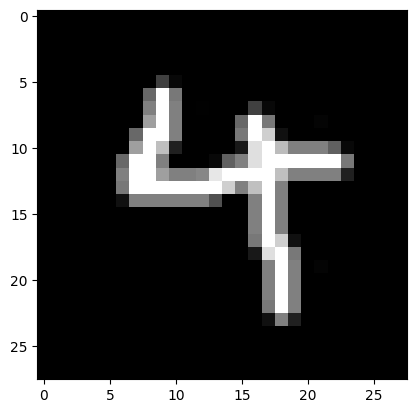

Most likely class is 4

Prob that image is a 0: 0.00%
Prob that image is a 1: 0.00%
Prob that image is a 2: 0.00%
Prob that image is a 3: 0.00%
Prob that image is a 4: 98.51%
Prob that image is a 5: 0.00%
Prob that image is a 6: 0.00%
Prob that image is a 7: 0.03%
Prob that image is a 8: 0.00%
Prob that image is a 9: 1.46%


In [26]:
# Evaluate network on ./number.png

# Define transformations to preprocess the image
# Custom transformation to flatten the image
class FlattenTransform:
    def __call__(self, tensor):
        return tensor.view(-1)  # Flatten the tensor

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])


# Load image
image = Image.open("./number.png")

# Preprocess the image so it's the right size and shape to be fed into the model
vis_image = transform(image)
image = vis_image.view(-1)
image = image.unsqueeze(0) # Add a batch dimension

plt.figure()
plt.imshow(vis_image.squeeze(), cmap="gray")
plt.show()

# Feed it into the network
model.eval()
with torch.no_grad():
    result = model(image)

result = nn.functional.softmax(result, dim=1)

# Print result
print(f"Most likely class is {int(result.argmax(dim=1))}\n")

for ind, i in enumerate(result[0]):
    print(f"Prob that image is a {ind}: {i*100:.2f}%")